<a href="https://colab.research.google.com/github/Ken-Lau-Lab/single-cell-lectures/blob/main/section04_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## __Section 4:__ Dimension Reduction Homework

February 22, 2022

---

In [1]:
!git clone git://github.com/Ken-Lau-Lab/single-cell-lectures  # for Colab users
!pip install scanpy  # for Colab users
!pip install leidenalg  # for Colab users
!pip install scikit-learn # for Colab users
!cp -r single-cell-lectures/data/ .  # for Colab users

Cloning into 'single-cell-lectures'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 173 (delta 88), reused 99 (delta 38), pack-reused 0
Receiving objects: 100% (173/173), 153.35 MiB | 21.30 MiB/s, done.
Resolving deltas: 100% (88/88), done.
     |████████████████████████████████| 2.0 MB 5.3 MB/s 
     |████████████████████████████████| 86 kB 3.3 MB/s 
     |████████████████████████████████| 91 kB 5.4 MB/s 
     |████████████████████████████████| 1.1 MB 32.2 MB/s 
     |████████████████████████████████| 63 kB 1.1 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=e11c6fb4ba6f27dc2a9268f099f5e1cbac187d8f8dca33a8b417b2a30e3c76de
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=e7634369

In [2]:
%env PYTHONHASHSEED=0
import scanpy as sc; sc.settings.verbosity = 3  # Set scanpy verbosity to 3 for in depth function run information
import numpy as np
import random; random.seed(22)
from sklearn.preprocessing import normalize
np.random.seed(22)

env: PYTHONHASHSEED=0


---
#### Import peripheral blood mononuclear cells (PBMC) dataset.  This has already been **filtered** and **feature-selected**.

#### Your assignment is to **perform principal component analysis** and determine **which gene features drive the major PCs in the dataset**.

In [3]:
adata = sc.read("data/PBMC_3k_small.h5ad") ; adata

AnnData object with n_obs × n_vars = 2625 × 1838
    var: 'gene_ids'

#### Below, I've included some code snippets that we used during the lecture for processing.

#### We don't need to worry about mitochondrial counts or cell cycle phase inference for this exercise.

In [4]:
# let's first define a custom function that operates on AnnData objects
def arcsinh_norm(adata, layer=None, norm="l1", scale=1000):
    """
    return arcsinh-normalized values for each element in anndata counts matrix
    l1 normalization (sc.pp.normalize_total) should be performed before this transformation
        adata = AnnData object
        layer = name of lauer to perform arcsinh-normalization on. if None, use AnnData.X
        norm = normalization strategy prior to Log2 transform.
            None: do not normalize data
            'l1': divide each count by sum of counts for each cell
            'l2': divide each count by sqrt of sum of squares of counts for cell
        scale = factor to scale normalized counts to; default 1000
    """
    if layer is None:
        mat = adata.X
    else:
        mat = adata.layers[layer]

    adata.layers["arcsinh_norm"] = np.arcsinh(normalize(mat, axis=1, norm=norm) * scale)

In [31]:
# preprocess AnnData for downstream dimensionality reduction
adata.layers["raw_counts"] = adata.X.copy()  # save raw counts in layer
arcsinh_norm(adata, layer="raw_counts", norm="l1", scale=1000)  # arcsinh-transform normalized counts and add to .layers['arcsinh_norm']
adata.X = adata.layers["arcsinh_norm"].copy()  # set normalized counts as .X slot in scanpy object


#### In the code block below, perform a **50-component PCA**, plot the overview containing the PC scatterplots, gene loadings, and variance ratio

In [32]:

s_genes_h = [
    "MCM5","PCNA","TYMS","FEN1","MCM2","MCM4","RRM1","UNG",
    "GINS2","MCM6","CDCA7","DTL","PRIM1","UHRF1","MLF1IP",
    "HELLS","RFC2","RPA2","NASP","RAD51AP1","GMNN","WDR76",
    "SLBP","CCNE2","UBR7","POLD3","MSH2","ATAD2","RAD51",
    "RRM2","CDC45","CDC6","EXO1","TIPIN","DSCC1","BLM","CASP8AP2",
    "USP1","CLSPN","POLA1","CHAF1B","BRIP1","E2F8",
]
g2m_genes_h = [
    "HMGB2","CDK1","NUSAP1","UBE2C","BIRC5","TPX2","TOP2A",
    "NDC80","CKS2","NUF2","CKS1B","MKI67","TMPO","CENPF",
    "TACC3","FAM64A","SMC4","CCNB2","CKAP2L","CKAP2","AURKB",
    "BUB1","KIF11","ANP32E","TUBB4B","GTSE1","KIF20B","HJURP",
    "CDCA3","HN1","CDC20","TTK","CDC25C","KIF2C","RANGAP1",
    "NCAPD2","DLGAP5","CDCA2","CDCA8","ECT2","KIF23","HMMR",
    "AURKA","PSRC1","ANLN","LBR","CKAP5","CENPE","CTCF",
    "NEK2","G2E3","GAS2L3","CBX5","CENPA",
]

def cc_score(adata, layer=None, seed=18, verbose=True):
    """
    Calculates cell cycle scores and implied phase for each observation

    Parameters
    ----------

    adata : anndata.AnnData
        object containing transformed and normalized (arcsinh or log1p) counts in 
        'layer'.
    layer : str, optional (default=None)
        key from adata.layers to use for cc phase calculation. Default None to 
        use .X
    seed : int, optional (default=18)
        random state for PCA, neighbors graph and clustering
    verbose : bool, optional (default=True)
        print updates to console

    Returns
    -------

    adata is edited in place to add 'G2M_score', 'S_score', and 'phase' to .obs
    """
    if layer is not None:
        adata.layers["temp"] = adata.X.copy()
        adata.X = adata.layers[layer].copy()
        if verbose:
            print("Calculating cell cycle scores using layer: {}".format(layer))
    else:
        if verbose:
            print("Calculating cell cycle scores")
   
    if any(item in adata.var_names for item in s_genes_h + g2m_genes_h):
        s_genes, g2m_genes = s_genes_h, g2m_genes_h
    elif any(item in adata.var_names for item in s_genes_m + g2m_genes_m):
        s_genes, g2m_genes = s_genes_m, g2m_genes_m
   
    sc.tl.score_genes_cell_cycle(
        adata,
        s_genes=s_genes,  
        g2m_genes=g2m_genes,  
        random_state=seed,
    )
    if layer is not None:
        adata.X = adata.layers["temp"].copy()
        del adata.layers["temp"]
cc_score(adata, layer="arcsinh_norm", seed=18, verbose=True)

Calculating cell cycle scores using layer: arcsinh_norm
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    126 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    169 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [34]:
sc.pp.highly_variable_genes(adata, n_top_genes=1835)


If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'phase' as categorical


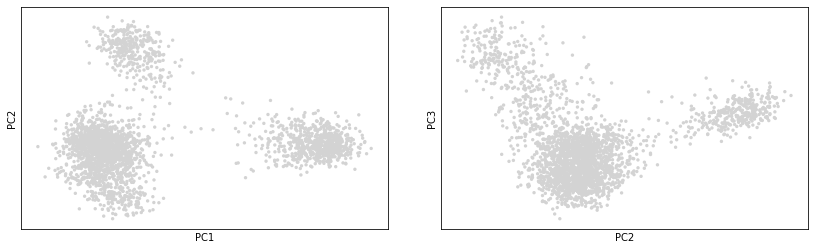

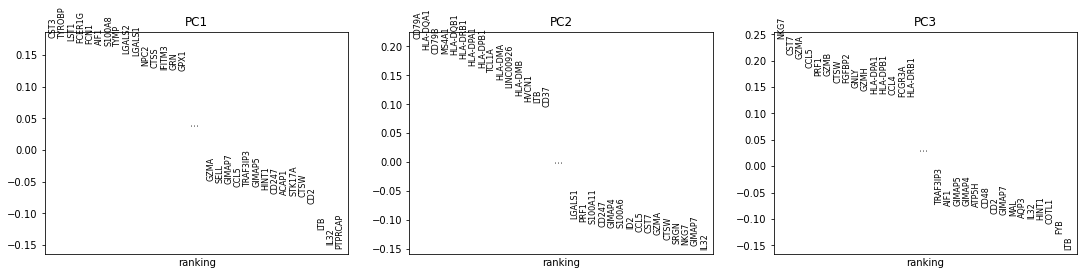

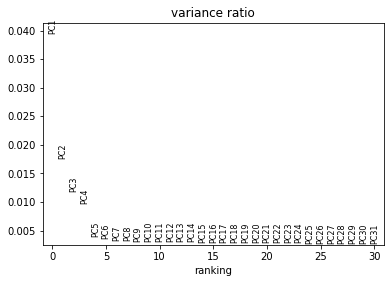

In [35]:

sc.tl.pca(adata, n_comps=50, random_state=0, use_highly_variable=True)  

sc.pl.pca_overview(
    adata,
    components=["1,2","2,3"],
)

#### List the **top 3 genes in each of the first 3 principal components**, which describe the "loadings" for the major PCs that explain the most variance across all cells

PC1- CST3, TYROBP, LST1
PC2- CD79A, HLA-DQA1, CD798
PC3- NKG7, CST7, GZMA